<a href="https://colab.research.google.com/github/quartermaine/Machine-Learning-Notebooks/blob/main/Forecasting/Insurance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this notebook, my aim was to forecast daily insurance claim amounts. Here's an overview of the steps I took in the analysis:

#### - Step 1: I began by aggregating the claim amounts for each day to get a clearer view of the data.

#### - Step 2: Next, I conducted an exploratory data analysis (EDA) using automated tools like Pandas Profiling, along with some custom visualizations, to uncover insights and patterns.

#### - Step 3: I divided the data into training and testing sets to prepare for model building.

#### - Step 4: Then, I constructed forecasting models using Prophet, both with and without regressors, and also experimented with XGBoost.

#### - Step 5: Finally, I visualized the model predictions and reported the performance metrics to evaluate their effectiveness in forecasting insurance claim amounts.


In [ ]:
#@title Libraries installations
%%capture
try:
  import ydata_profiling
except ImportError:
  !pip install ydata_profiling

!pip install hvplot holoviews



In [ ]:
#@title Libraries imports
# pandas
import pandas as pd
# pycaret
# from pycaret.regression import *
# plotly
import plotly.graph_objects as go
import plotly.express as px
# holoviews
import holoviews as hv
import hvplot.pandas
from holoviews import opts
from bokeh.io import output_notebook
# sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, mean_squared_error, r2_score
# data profiling - quick EDA
from ydata_profiling import ProfileReport
# matplotlib
import matplotlib.pyplot as plt
#seaborn
import seaborn as sns
# prophet
from prophet import Prophet
# xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Set plot style and palette
# plt.style.use('dark_background')
sns.set_palette('deep')

In [ ]:
#@title Function definitions

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    # df.set_index('ds', inplace=True)
    # df['date'] = df.index
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week


    # Add rolling window statistics
    # df['rolling_mean_3'] = df['y'].rolling(window=3).mean()
    # df['rolling_std_3'] = df['y'].rolling(window=3).std()
    # df['rolling_max_3'] = df['y'].rolling(window=3).max()
    # df['rolling_min_3'] = df['y'].rolling(window=3).min()

    # df.fillna(0, inplace=True)  # Replace NaNs created by rolling windows

    return df

import statsmodels.api as sm

def decompose(df, column_name):
    """
    A function that returns the trend, seasonality, and residual captured by applying both multiplicative and
    additive models.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert the 'ds' column to a DateTimeIndex
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    df_copy.set_index('ds', inplace=True)

    # Decompose the time series using the statsmodels seasonal decompose function
    decomposition = sm.tsa.seasonal_decompose(df_copy[column_name], model='additive')

    # Plot the decomposed components
    plt.rcParams.update({'figure.figsize': (20, 10)})
    decomposition.plot()
    plt.suptitle('Additive Decompose', fontsize=20)
    plt.show()

    return decomposition

def build_model():
    """Define forecasting model."""
    model = Prophet(
        # yearly_seasonality=True,
        # weekly_seasonality=True,
        # daily_seasonality=True,
        # holidays = holidays,
        interval_width=0.95,
        # mcmc_samples = 1000,
        changepoint_prior_scale=0.5,  # Adjust changepoint prior scale
        seasonality_mode='multiplicative',  # Use multiplicative seasonality if suitable
        # seasonality_prior_scale=10.0  # Adjust seasonality prior scale
        # growth= 'flat'
    )

    # model.add_seasonality(
    #     name='daily',
    #     period=5,
    #     fourier_order=5
    # )

    return model

def plot_forecast(forecast, df_train, df_test, forecast_train, forecast_test, threshold_date):
    fig = go.Figure()

    # Adding the 95% credible interval
    fig.add_trace(go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_upper'],
        mode='lines',
        line=dict(width=0),
        name='Upper CI',
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_lower'],
        mode='lines',
        fill='tonexty',
        line=dict(width=0),
        fillcolor='rgba(0,100,80,0.2)',
        name='95% CI'
    ))

    # Adding the actual train data
    fig.add_trace(go.Scatter(
        x=df_train['ds'],
        y=df_train['y'],
        mode='lines',
        name='y_train'
    ))

    # Adding the actual test data
    fig.add_trace(go.Scatter(
        x=df_test['ds'],
        y=df_test['y'],
        mode='lines',
        name='y_test'
    ))

    # Adding the predicted train data
    fig.add_trace(go.Scatter(
        x=forecast_train['ds'],
        y=forecast_train['yhat'],
        mode='lines',
        name='y_hat_train'
    ))

    # Adding the predicted test data
    fig.add_trace(go.Scatter(
        x=forecast_test['ds'],
        y=forecast_test['yhat'],
        mode='lines',
        name='y_hat_test'
    ))

    # Adding the train-test split line
    fig.add_trace(go.Scatter(
        x=[threshold_date, threshold_date],
        y=[min(forecast['yhat_lower']), max(forecast['yhat_upper'])],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='train test split'
    ))

    # Updating layout
    fig.update_layout(
        title='Dependent Variable',
        xaxis_title='Date',
        yaxis_title='',
        template='plotly_dark',
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder='normal'
        )
    )

    fig.show()


In [ ]:
#@title Data loading and fetures selection (add the path of the file)

dataset = pd.read_csv("/content/insurance_data_sample.csv")

# dataset.head()

cols_to_keep = [
    'Gender',
    'Annual Income',
    'Company',
    'Model',
    'Engine',
    'Transmission',
    'Color',
    'Price ($)',
    'Body Style',
    'Amount_paid_for_insurance',
    'Claim amount',
    'City'
    ]

df = dataset[cols_to_keep]

df.head()


Gender  Annual Income   Company       Model                       Engine  \
0   Male          13500      Ford  Expedition  DoubleÃ‚Â Overhead Camshaft   
1   Male        1480000     Dodge     Durango  DoubleÃ‚Â Overhead Camshaft   
2   Male        1035000  Cadillac    Eldorado            Overhead Camshaft   
3   Male          13500    Toyota      Celica            Overhead Camshaft   
4   Male        1465000     Acura          TL  DoubleÃ‚Â Overhead Camshaft   

  Transmission       Color  Price ($) Body Style  Amount_paid_for_insurance  \
0         Auto       Black      26000        SUV                       1665   
1         Auto       Black      19000        SUV                       1332   
2       Manual         Red      31500  Passenger                       1897   
3       Manual  Pale White      14000        SUV                       1176   
4         Auto         Red      24500  Hatchback                       1323   

   Claim amount     City  
0           0.0     Riga  
1        1900.0  Liepaja  
2           0.0     Riga  
3           0.0  Jelgava  
4        2450.0  Liepaja

In [ ]:
#@title Auto-EDA
profile = ProfileReport(df,
                        title="EDA on dataset"
                        )
#
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#@title Annual Income vs Claim Amount

# Create scatter plot for Annual Income vs Claim amount with categorical color
scatter_annual_income_claim = px.scatter(df,
                                         x='Annual Income',
                                         y='Claim amount',
                                         color='Gender',
                                         trendline='ols',
                                         title='Annual Income vs Claim Amount',
                                         labels={'Annual Income': 'Annual Income ($)', 'Claim amount': 'Claim Amount ($)'},
                                         template='plotly_dark')

# Display the scatter plot
scatter_annual_income_claim.show()


In [ ]:
#@title Averages Amount Plid for Insurance by Body Type

# Calculate average amount paid for insurance for each Body Style
average_insurance_by_body_style = df.groupby('Body Style')['Amount_paid_for_insurance'].mean().reset_index()

# Sort the dataframe by average amount paid for insurance in descending order
average_insurance_by_body_style = average_insurance_by_body_style.sort_values(by='Amount_paid_for_insurance', ascending=False)

# Create a bar plot
bar_plot = px.bar(average_insurance_by_body_style, x='Body Style', y='Amount_paid_for_insurance',
                  title='Average Amount Paid for Insurance by Body Style',
                  labels={'Amount_paid_for_insurance': 'Average Amount Paid for Insurance ($)'},
                  color='Body Style',
                  template='plotly_dark')

# Show the bar plot
bar_plot.show()


In [ ]:
#@title Price ($) vs Amount Paid for Insurance

# Scatter Plot of Price ($) vs Amount Paid for Insurance
scatter_price_vs_insurance = px.scatter(df,
                                        x='Price ($)',
                                        y='Amount_paid_for_insurance',
                                        title='Scatter Plot of Price ($) vs Amount Paid for Insurance',
                                        labels={'Price ($)': 'Price ($)', 'Amount_paid_for_insurance': 'Amount Paid for Insurance ($)'},
                                        trendline='ols',
                                        template='plotly_dark'
                                        )




# Show the scatter plots
scatter_price_vs_insurance.show()


In [ ]:
#@title Prepare dataset for prophet

dt = dataset[['Date','Claim amount']]

# dt.head()

# Data Preparation
# Convert the date column to datetime
dt['Date'] = pd.to_datetime(dt['Date'])

# Set the date column as the index
dt.set_index('Date', inplace=True)

# Aggregate daily claim amounts
df_prophet = dt.resample('D').sum()

# Rename the columns
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

print(df_prophet)

            ds        y
0   2022-01-02   6450.0
1   2022-01-03  11900.0
2   2022-01-04   2900.0
3   2022-01-05   4100.0
4   2022-01-06   1600.0
..         ...      ...
724 2023-12-27   5050.0
725 2023-12-28      0.0
726 2023-12-29  51826.0
727 2023-12-30   4250.0
728 2023-12-31   8300.0

[729 rows x 2 columns]


<ipython-input-9-f78409af01b7>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title Check for missing dates

# Get the minimum and maximum dates from the DataFrame
min_date = df_prophet['ds'].min()
max_date = df_prophet['ds'].max()

# Create a complete DateTime index covering the entire date range
complete_index = pd.date_range(start=min_date, end=max_date, freq='D')

# Check for missing dates
missing_dates = complete_index[~complete_index.isin(df_prophet['ds'])]

# Print the missing dates, if any
if len(missing_dates) == 0:
    print("No missing dates.")
else:
    print("Missing dates:")
    print(missing_dates)


No missing dates.


In [ ]:
#@title Average sales per Week Day

# Create features
df_with_features = create_features(df_prophet)

# Group by day of the week and month to calculate average sales
avg_sales_dayofweek = df_with_features.groupby('dayofweek')['y'].mean().reset_index()
avg_sales_month = df_with_features.groupby('month')['y'].mean().reset_index()

# Map dayofweek to day names
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
avg_sales_dayofweek['dayofweek'] = avg_sales_dayofweek['dayofweek'].map(day_names)

# Map month to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
avg_sales_month['month'] = avg_sales_month['month'].map(month_names)

# Plot average sales per day of the week with different colors
fig_dayofweek = px.bar(avg_sales_dayofweek, x='dayofweek', y='y',
                       labels={'dayofweek': 'Day of Week', 'y': 'Average Sales'},
                       template='plotly_dark',
                       title='Average Cliamns per Day of the Week', color='dayofweek')
fig_dayofweek.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# Plot average sales per month with different colors
fig_month = px.bar(avg_sales_month, x='month', y='y',
                   labels={'month': 'Month', 'y': 'Average Sales'},
                   template='plotly_dark',
                   title='Average Claims per Month', color='month')
fig_month.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# Show the plots
fig_dayofweek.show()

In [ ]:
#@title Average Sales per Month

fig_month.show()

In [ ]:
# Create a new column to identify if the date is a weekday or weekend
# df_prophet['day_type'] = df_prophet['ds'].apply(lambda x: 'Weekend' if x.weekday() >= 5 else 'Weekday')
# df_prophet


In [ ]:
#@title Claim amount per day

# sns.set_style('darkgrid', {'axes.facecolor': '.9'})
# sns.set_palette(palette='deep')
# sns_c = sns.color_palette(palette='deep')

# fig, ax = plt.subplots(figsize=(20, 12))
# ax.plot(df_prophet['ds'],
#         df_prophet['y'],
#         label='sales',
#         linewidth=1)

# #add title and axis labels
# plt.title('Revenue by Date no Weekends')
# plt.title('Revenue by Date')
# plt.xlabel('Date')
# plt.ylabel('Revenue')

# #display plot
# plt.show()

def plot_revenue(df):
    fig = go.Figure()

    # Add the sales line
    fig.add_trace(go.Scatter(
        x=df['ds'],
        y=df['y'],
        mode='lines',
        name='sales',
        line=dict(width=1)
    ))

    # Update layout to add title and axis labels
    fig.update_layout(
        title='Revenue by Date no Weekends',
        xaxis_title='Date',
        yaxis_title='Revenue',
        template='plotly_dark'  # Apply a dark theme similar to seaborn's 'darkgrid'
    )

    # Show the plot
    fig.show()

# Example usage
plot_revenue(df_prophet)



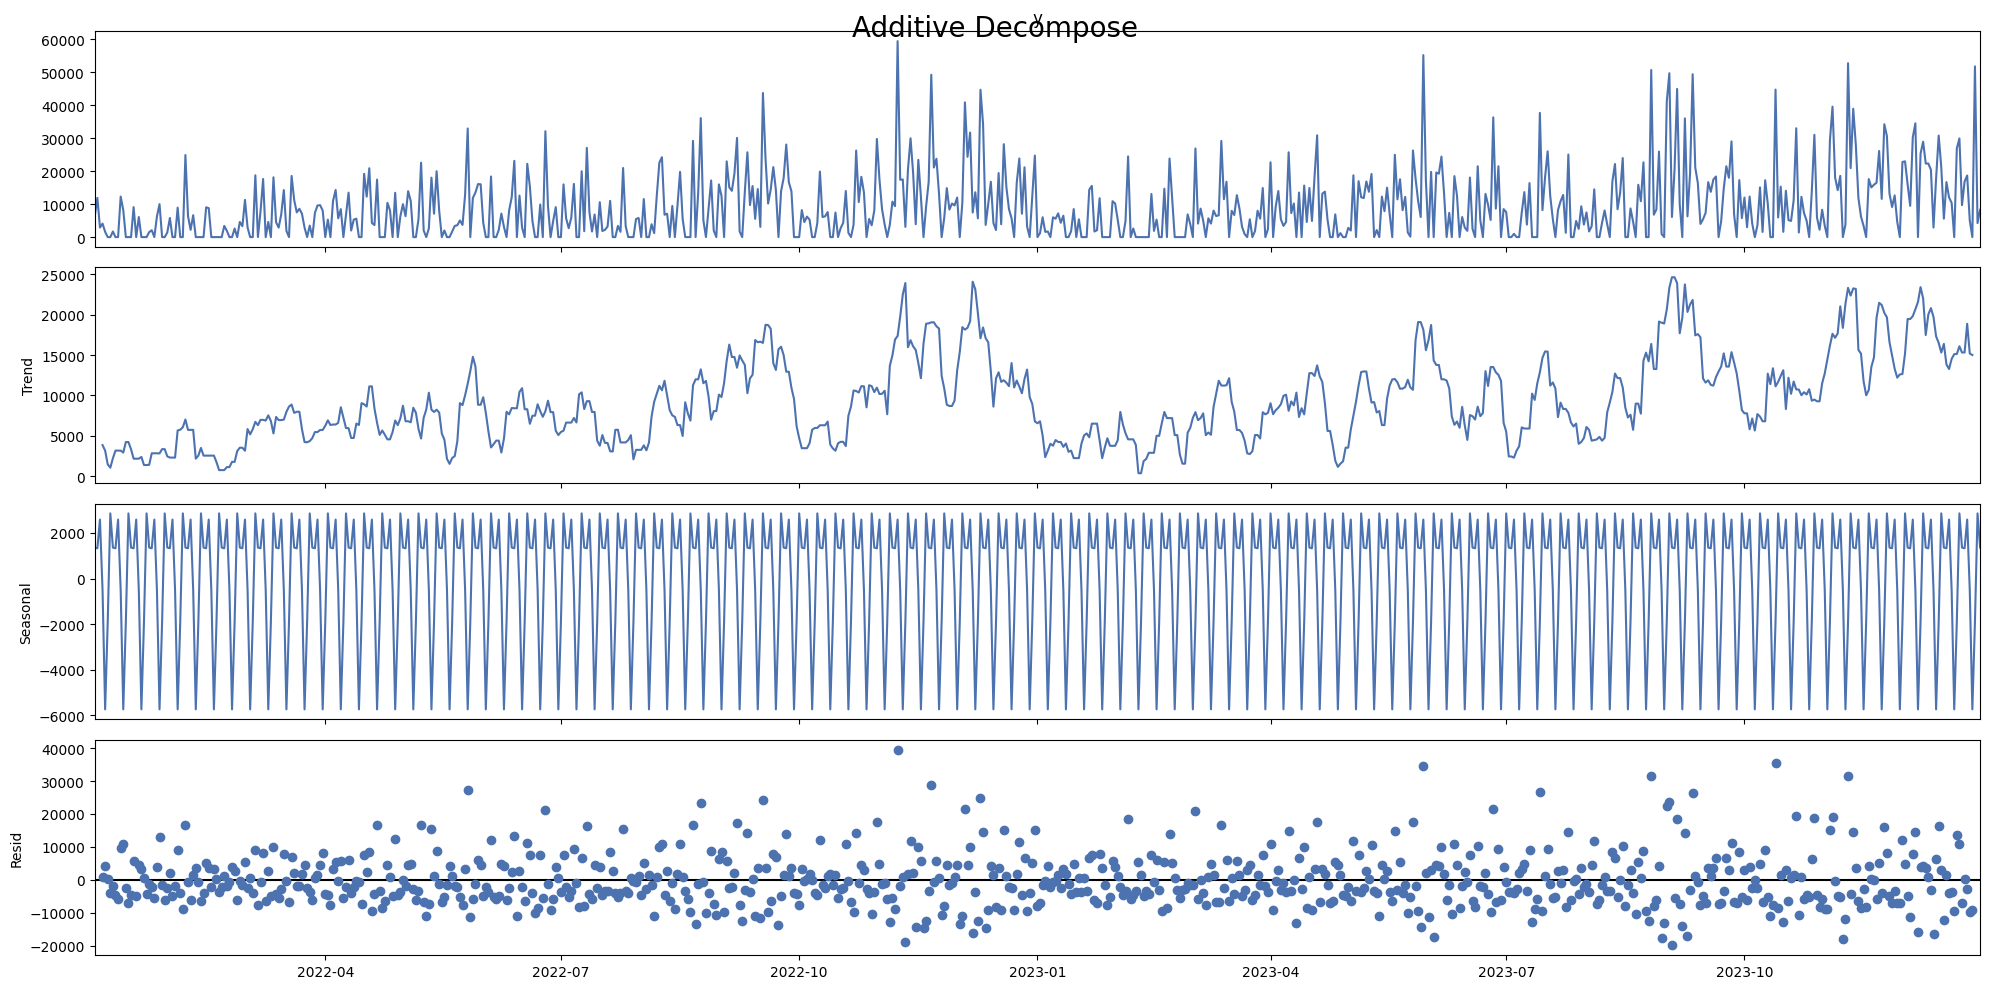

In [ ]:
#@title Decomposition

result_add = decompose(df_prophet, 'y')


In [ ]:
#@title Split data train/test

threshold_date = pd.to_datetime('2023-10-01')
mask = df_prophet['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train = df_prophet[mask][['ds', 'y']]
df_test = df_prophet[~ mask][['ds', 'y']]


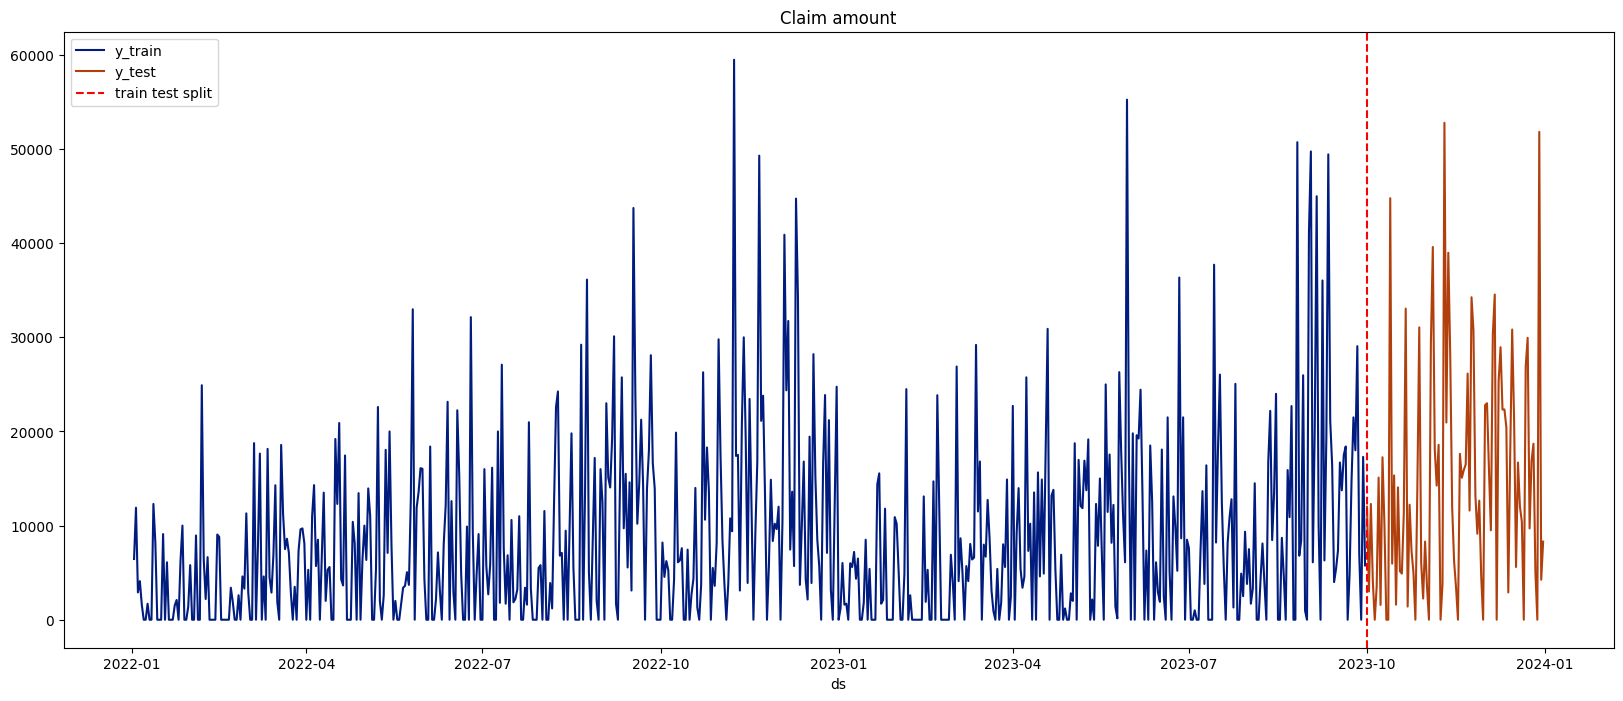

In [ ]:
#@title Data Split Plot

# Define a dark color palette
sns.set_palette("dark")

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot y_train and y_test lines
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)

# Add vertical line for train test split
ax.axvline(threshold_date, color='red', linestyle='--', label='train test split')

# Add legend and title
ax.legend(loc='upper left')
ax.set(title='Claim amount', ylabel='')

# Show the plot
plt.show()

# import datetime

# # Create a figure
# fig = go.Figure()

# # Add the y_train line
# fig.add_trace(go.Scatter(
#     x=df_train['ds'],
#     y=df_train['y'],
#     mode='lines',
#     name='y_train',
#     line=dict(color='black')
# ))

# # Add the y_test line
# fig.add_trace(go.Scatter(
#     x=df_test['ds'],
#     y=df_test['y'],
#     mode='lines',
#     name='y_test',
#     line=dict(color='black', dash='dash')
# ))

# # Add vertical line for train test split
# fig.add_vline(
#     x=threshold_date,
#     line=dict(color='red', dash='dash'),
#     annotation_text='train test split',
#     annotation_position='top left'
# )

# # Update layout to add title and axis labels
# fig.update_layout(
#     title='Dependent Variable',
#     xaxis_title='Date',
#     yaxis_title='',
#     template='plotly_dark',
#     legend=dict(
#         x=0.01,
#         y=0.99,
#         traceorder='normal'
#     )
# )

# # Show the plot
# fig.show()

In [ ]:
threshold_date

Timestamp('2023-10-01 00:00:00')

In [ ]:
#@title _

# hv.extension('bokeh')
# output_notebook()

# # Create HoloViews plots
# train_plot = df_train.hvplot.line(x='ds', y='y', label='y_train', line_width=2)
# test_plot = df_test.hvplot.line(x='ds', y='y', label='y_test', line_width=2)

# # Vertical line for train-test split
# split_line = hv.VLine(threshold_date).opts(color='red', line_dash='dashed', line_width=2)

# # Combine plots
# combined_plot = (train_plot * test_plot * split_line).opts(
#     opts.Overlay(
#         title="Claim amount per day",
#         legend_position='top_left',
#         width=1400,
#         height=600,
#         # xformatter='%d-%m-%Y',
#         xlabel='Date',
#         ylabel='',
#         bgcolor='#2b2b2b'
#     ),
#     opts.VLine(color='red', line_dash='dashed')
# )

# # Display the plot
# combined_plot


In [ ]:
#@title Fit prophet model & forecasts

model = build_model()

model.fit(df_train)

# Extend dates and features.
horizon = df_test.shape[0]

future = model.make_future_dataframe(periods=horizon, freq='D') # daily days predictions
# future = model.make_future_dataframe(periods=horizon, freq='B') # business days predictions
# Generate predictions.
forecast = model.predict(df=future)

forecast.loc[:, 'yhat'] = forecast['yhat'].clip(lower=0)
forecast.loc[:, 'yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshgun2y3/mp725ppe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshgun2y3/0qtnbow0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24069', 'data', 'file=/tmp/tmpshgun2y3/mp725ppe.json', 'init=/tmp/tmpshgun2y3/0qtnbow0.json', 'output', 'file=/tmp/tmpshgun2y3/prophet_modelzfllrtc2/prophet_model-20240603072317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


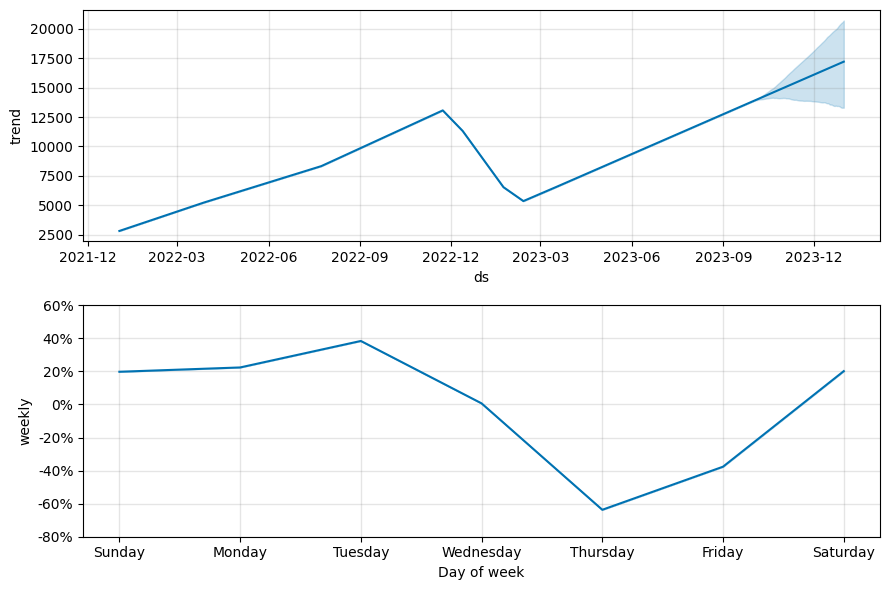

In [ ]:
#@title Plot components

fig = model.plot_components(forecast)



In [ ]:
#@title Plot prophet forecasts

# fig, ax = plt.subplots(figsize=(20, 12))

# ax.fill_between(
#     x=forecast['ds'],
#     y1=forecast['yhat_lower'],
#     y2=forecast['yhat_upper'],
#     color=sns_c[2],
#     alpha=0.25,
#     label=r'0.95 credible_interval'
# )

# sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
# sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_train, ax=ax)
# sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
# ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
# ax.legend(loc='upper left')
# ax.set(title='Dependent Variable', ylabel='')
# sns.despine()

plot_forecast(forecast,
              df_train,
              df_test,
              forecast_train,
              forecast_test,
              threshold_date
              )


In [ ]:
#@title Metrics

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate MAE and R-squared
mae = mean_absolute_error(df_test['y'], forecast_test['yhat'])
r2 = r2_score(df_test['y'], forecast_test['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 9917.821857650051
R-squared (R²): -0.05425134261500908


In [ ]:
#@title _

# hv.extension('bokeh')
# output_notebook()

# # Create HoloViews elements
# train_curve = df_train.hvplot.line(x='ds', y='y', label='y_train', line_width=2, color='blue')
# test_curve = df_test.hvplot.line(x='ds', y='y', label='y_test', line_width=2, color='green')
# forecast_curve_train = forecast_train.hvplot.line(x='ds', y='yhat', label='y_hat', line_width=2, color='orange')
# forecast_curve_test = forecast_test.hvplot.line(x='ds', y='yhat', label='y_hat', line_width=2, color='orange')
# forecast_band = hv.Area((forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper']), vdims=['yhat_lower', 'yhat_upper']).opts(
#          color='orange', alpha=0.25, )
# split_line = hv.VLine(threshold_date).opts(color='red', line_dash='dashed', line_width=2)

# # Combine plots
# combined_plot = (train_curve * test_curve * forecast_curve_train * forecast_curve_test * forecast_band * split_line).opts(
#     opts.Overlay(
#         title="Dependent Variable",
#         legend_position='top_left',
#         width=1400,
#         height=600,
#         xlabel='Date',
#         ylabel='',
#         bgcolor='#2b2b2b'
#     )
# )

# # Display the plot
# hv.output(combined_plot)


In [ ]:
#@title Add regressors

df_with_feats_tr = create_features(df_train)

# df_with_feats_tr.head()

df_with_feats_test = create_features(df_test)

# df_with_feats_test.head()

In [ ]:
#@title Fit Prophet model & forecasts

model_with_feats = build_model()

model_with_feats.add_regressor('dayofweek')
model_with_feats.add_regressor('quarter')
model_with_feats.add_regressor('month')
model_with_feats.add_regressor('year')
model_with_feats.add_regressor('dayofyear')
model_with_feats.add_regressor('dayofmonth')
model_with_feats.add_regressor('weekofyear')

model_with_feats.fit(df_with_feats_tr)

# Extend dates and features.
horizon_with_feats = df_with_feats_test.shape[0]

future_with_feats = model_with_feats.make_future_dataframe(periods=horizon_with_feats, freq='D') # daily days predictions

future_with_feats['dayofweek'] = future_with_feats['ds'].dt.dayofweek
future_with_feats['quarter'] = future_with_feats['ds'].dt.quarter
future_with_feats['month'] = future_with_feats['ds'].dt.month
future_with_feats['year'] = future_with_feats['ds'].dt.year
future_with_feats['dayofyear'] = future_with_feats['ds'].dt.dayofyear
future_with_feats['dayofmonth'] = future_with_feats['ds'].dt.day
future_with_feats['weekofyear'] = future_with_feats['ds'].dt.isocalendar().week
# Ensure all columns are correctly typed
for col in ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']:
    future_with_feats[col] = future_with_feats[col].astype(int)
# print(future_with_feats)

# future = model.make_future_dataframe(periods=horizon, freq='B') # business days predictions
# Generate predictions.
forecast_with_feats = model_with_feats.predict(df=future_with_feats)

forecast_with_feats.loc[:, 'yhat'] = forecast_with_feats['yhat'].clip(lower=0)
forecast_with_feats.loc[:, 'yhat_lower'] = forecast_with_feats['yhat_lower'].clip(lower=0)

mask2_with_feats = forecast_with_feats['ds'] < threshold_date

forecast_with_feats_train = forecast_with_feats[mask2_with_feats]
forecast_with_feats_test = forecast_with_feats[~ mask2_with_feats]



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshgun2y3/tjqxek89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshgun2y3/gqti89u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45485', 'data', 'file=/tmp/tmpshgun2y3/tjqxek89.json', 'init=/tmp/tmpshgun2y3/gqti89u5.json', 'output', 'file=/tmp/tmpshgun2y3/prophet_modelxubnv4hd/prophet_model-20240603072318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


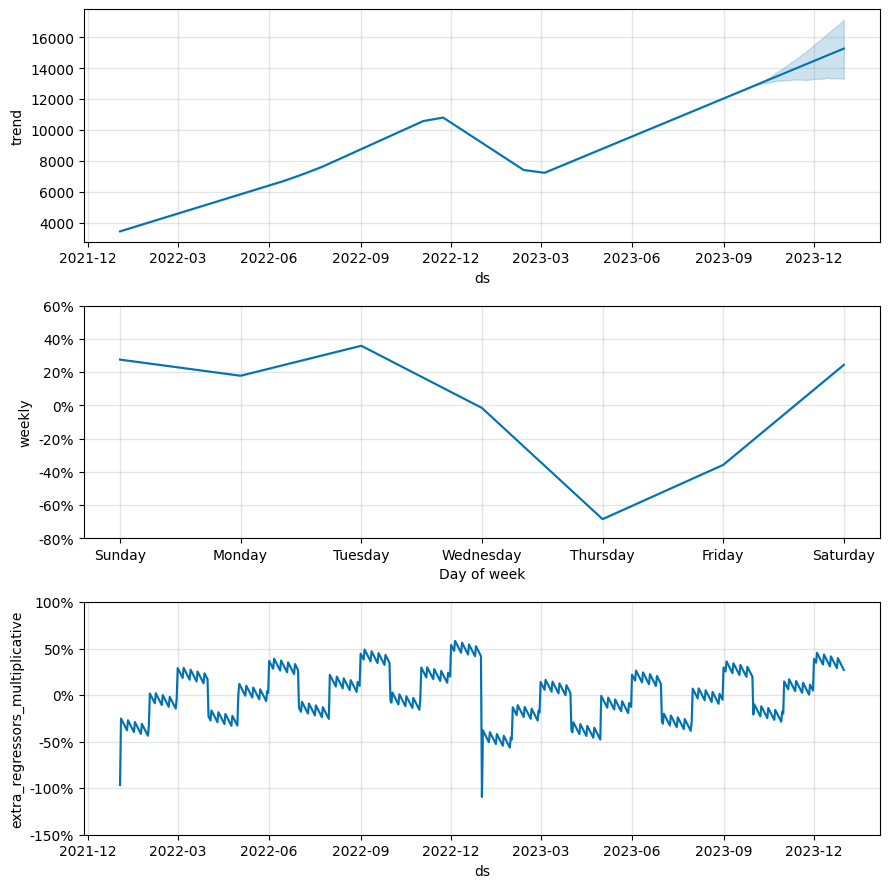

In [ ]:
#@title Plot components

fig = model_with_feats.plot_components(forecast_with_feats)

In [ ]:
#@title Plot forecasts with regressors

# fig, ax = plt.subplots(figsize=(20, 12))

# ax.fill_between(
#     x=forecast_with_feats['ds'],
#     y1=forecast_with_feats['yhat_lower'],
#     y2=forecast_with_feats['yhat_upper'],
#     color=sns_c[2],
#     alpha=0.25,
#     label=r'0.95 credible_interval'
# )

# sns.lineplot(x='ds', y='y', label='y_train', data=df_with_feats_tr, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_with_feats_test, ax=ax)
# sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_with_feats_train, ax=ax)
# sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_with_feats_test, ax=ax)
# ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
# ax.legend(loc='upper left')
# ax.set(title='Dependent Variable', ylabel='')
# sns.despine()

plot_forecast(forecast_with_feats,
              df_with_feats_tr,
              df_with_feats_test,
              forecast_with_feats_train,
              forecast_with_feats_test,
              threshold_date
              )


In [ ]:
#@title Metrics with regressors

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate MAE and R-squared
mae = mean_absolute_error(df_with_feats_test['y'], forecast_with_feats_test['yhat'])
r2 = r2_score(df_with_feats_test['y'], forecast_with_feats_test['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 9390.128782056445
R-squared (R²): 0.009595700581916056


In [ ]:
# # Round predictions to the nearest integer
# results_rounded = forecast_with_feats_test['yhat'].round().astype(int)

# # Calculate MAE and R-squared using rounded predictions
# mae = mean_absolute_error(df_with_feats_test['y'], results_rounded)
# r2 = r2_score(df_with_feats_test['y'], results_rounded)

# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R²): {r2}")


In [ ]:
#@title XgBoost model

df_with_feats_tr = create_features(df_train)

# Prepare features (X) and target (y)
X_train = df_with_feats_tr[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y_train = df_with_feats_tr['y']


df_with_feats_test = create_features(df_test)

# Prepare features (X) and target (y)
X_test = df_with_feats_test[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y_test = df_with_feats_test['y']

model = xgb.XGBRegressor(estimators= 5000,
    objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[07:23:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "estimators" } are not used.




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, estimators=5000, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

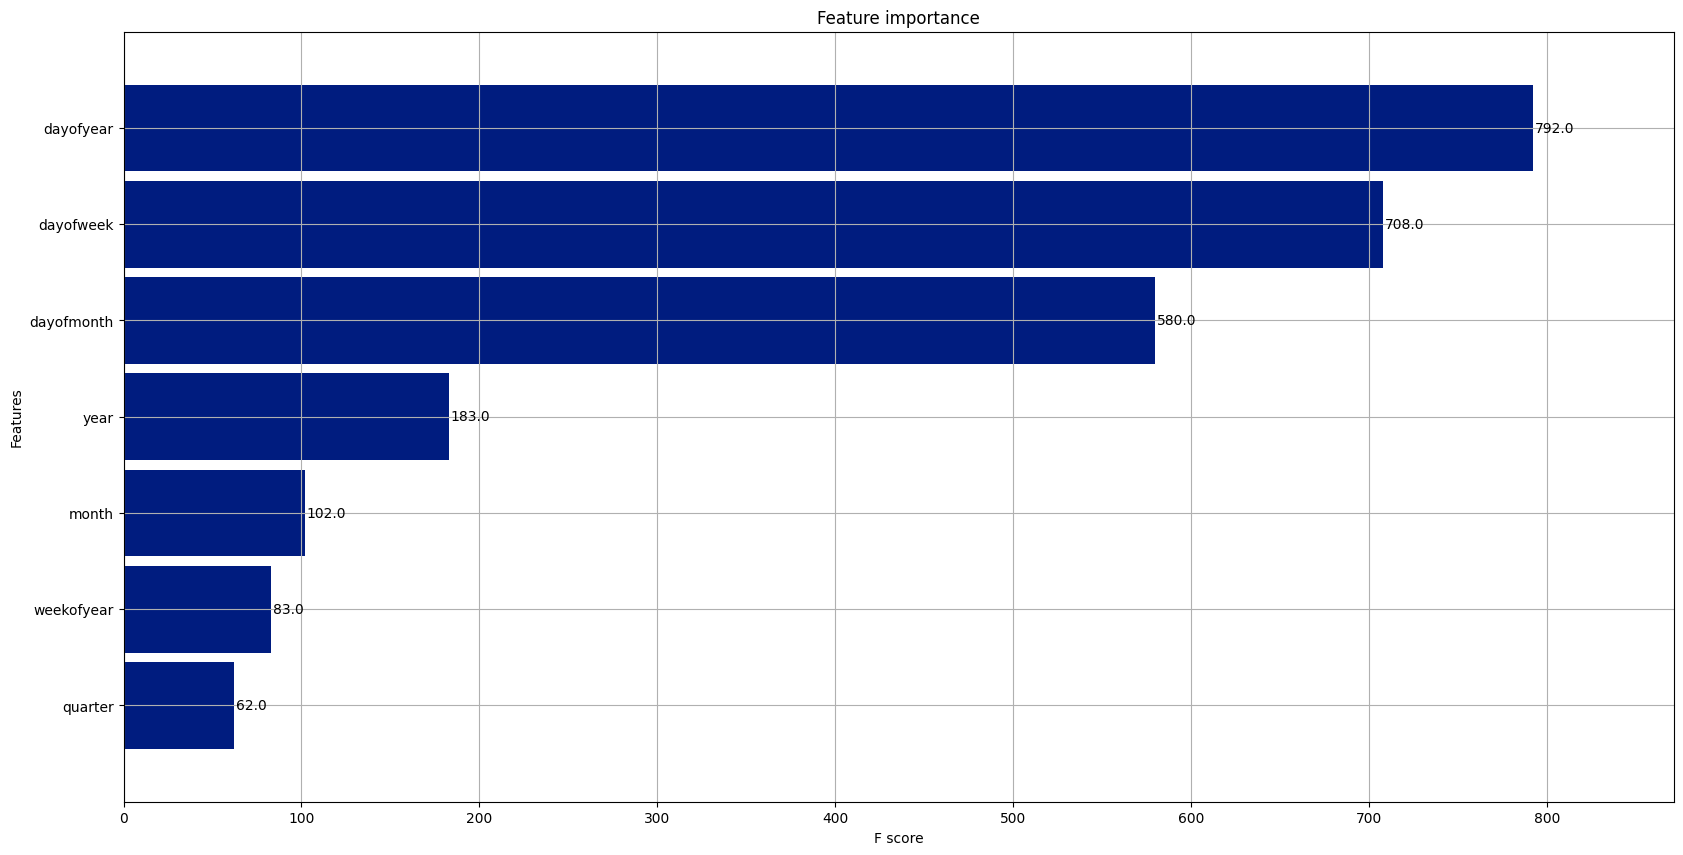

In [ ]:
#@title Feature Importance

_ = plot_importance(model, height=0.9)


In [ ]:
#@title Plot XgBoost predictions

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# # Plot the results
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(y_test.values, label='Actual', color='blue')
# plt.plot(y_pred_test, label='Predicted', color='red')
# plt.title('Actual vs Predicted Claim Amounts')
# plt.xlabel('Samples')
# plt.ylabel('Claim Amount')
# plt.legend()
# plt.show()
import plotly.graph_objs as go

# Create traces
import plotly.graph_objs as go

# Create traces
import plotly.graph_objs as go

# Create traces
trace_train_actual = go.Scatter(
    x=df.index[:len(y_train)],
    y=y_train.values,
    mode='lines',
    name='Actual Train',
    line=dict(color='blue')
)

trace_test_actual = go.Scatter(
    x=df.index[len(y_train):],
    y=y_test.values,
    mode='lines',
    name='Actual Test',
    line=dict(color='green')
)

trace_train_pred = go.Scatter(
    x=df.index[:len(y_train)],
    y=y_pred_train,
    mode='lines',
    name='Predicted Train',
    line=dict(color='orange')
)

trace_test_pred = go.Scatter(
    x=df.index[len(y_train):],
    y=y_pred_test,
    mode='lines',
    name='Predicted Test',
    line=dict(color='red')
)

# Combine traces
data = [trace_train_actual, trace_test_actual, trace_train_pred, trace_test_pred]

# Layout
layout = go.Layout(
    title='Actual vs Predicted Claim Amounts',
    xaxis=dict(title='Dates'),
    yaxis=dict(title='Claim Amount'),
    template='plotly_dark'
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()



In [ ]:
#@title Metrics

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


r2 train: 0.19526747001938471
r2 test: -0.05425134261500908
------------------------------
mae train: 6469.388992154569
mae test: 9917.821857650051


In [ ]:
#@title _

# # Evaluate the model
# train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
# test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
# train_r2 = r2_score(y_train, y_pred_train)
# test_r2 = r2_score(y_test, y_pred_test)

# print(f"Train RMSE: {train_rmse}")
# print(f"Test RMSE: {test_rmse}")
# print(f"Train R2: {train_r2}")
# print(f"Test R2: {test_r2}")


### Based on the analysis and visualizations conducted, several key findings emerged:

#### **Day-of-Week Seasonality**: The analysis revealed a noticeable pattern in claim amounts based on the day of the week. Specifically, Thursdays consistently exhibited lower claim amounts compared to other days, suggesting a potential weekday seasonality effect.

#### **Monthly Variation**: Analysis of the data highlighted variations in average claim amounts across different months. Particularly, months like September, November, and December showed higher average claim amounts compared to other months, indicating potential seasonal trends or external factors influencing insurance claims during these periods.

#### **Lack of Yearly Seasonality**: Interestingly, there was no discernible seasonal pattern based on the year but there is an increasing trend. This finding may be attributed to the limited dataset spanning only two years, suggesting that additional data covering a longer timeframe could provide more insights into yearly variations.

#### **Important Features**: Feature importance analysis indicated that the day of the year and the day of the week were the most significant predictors of claim amounts. Additionally, the day of the month also played a notable role in determining claim amounts, as revealed by feature importance plots generated during the analysis.

#### **Model Performance**: While the XGBoost model showed slightly improved performance compared to other models, overall model performance was suboptimal. This suggests that the current models may not adequately capture the complexities of the data. With the inclusion of additional data, such as another year's worth of observations, there is potential for improving model performance and achieving a better fit to the data.

